In [1]:
import os
import tarfile
import numpy

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import radical.analytics as ra

import itertools
colors = itertools.cycle(['tab:blue', 'tab:orange'])

plt.style.use(ra.get_mplstyle('radical_mpl'))

In [2]:
! radical-stack


  python               : /root/miniconda3/bin/python3
  pythonpath           : 
  version              : 3.7.6
  virtualenv           : base

  radical.analytics    : 1.6.7
  radical.entk         : 1.9.0
  radical.gtod         : 1.5.0
  radical.pilot        : 1.10.0
  radical.saga         : 1.8.0
  radical.utils        : 1.9.0



In [3]:
sids = ['re.session.login1.litan.018960.0000',
        're.session.login3.litan.018959.0000',
        're.session.login1.litan.018944.0008']
sdir = '../sessions/'
sessions = [sdir+s for s in sids]

for sid in sids:
    sp = sdir+sid+'.tar.bz2'
    tar = tarfile.open(sp, mode='r:bz2')
    tar.extractall(path=sdir)
    tar.close()

ss = {}
for sid in sids:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot', inplace=False),
                    't': ss[sid]['s'].filter(etype='task' , inplace=False)})

for sid in sids:
    ss[sid].update({'cores_node': ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
                    'pid'       : ss[sid]['p'].list('uid'),
                    'ntask'     : len(ss[sid]['t'].get())
    })

    ss[sid].update({'ncores'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'     : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']
    })

    ss[sid].update({'nnodes'    : int(ss[sid]['ncores']/ss[sid]['cores_node'])})

Text(0.5, -0.3, 'Time (s)')

findfont: Font family ['[serif]'] not found. Falling back to DejaVu Sans.


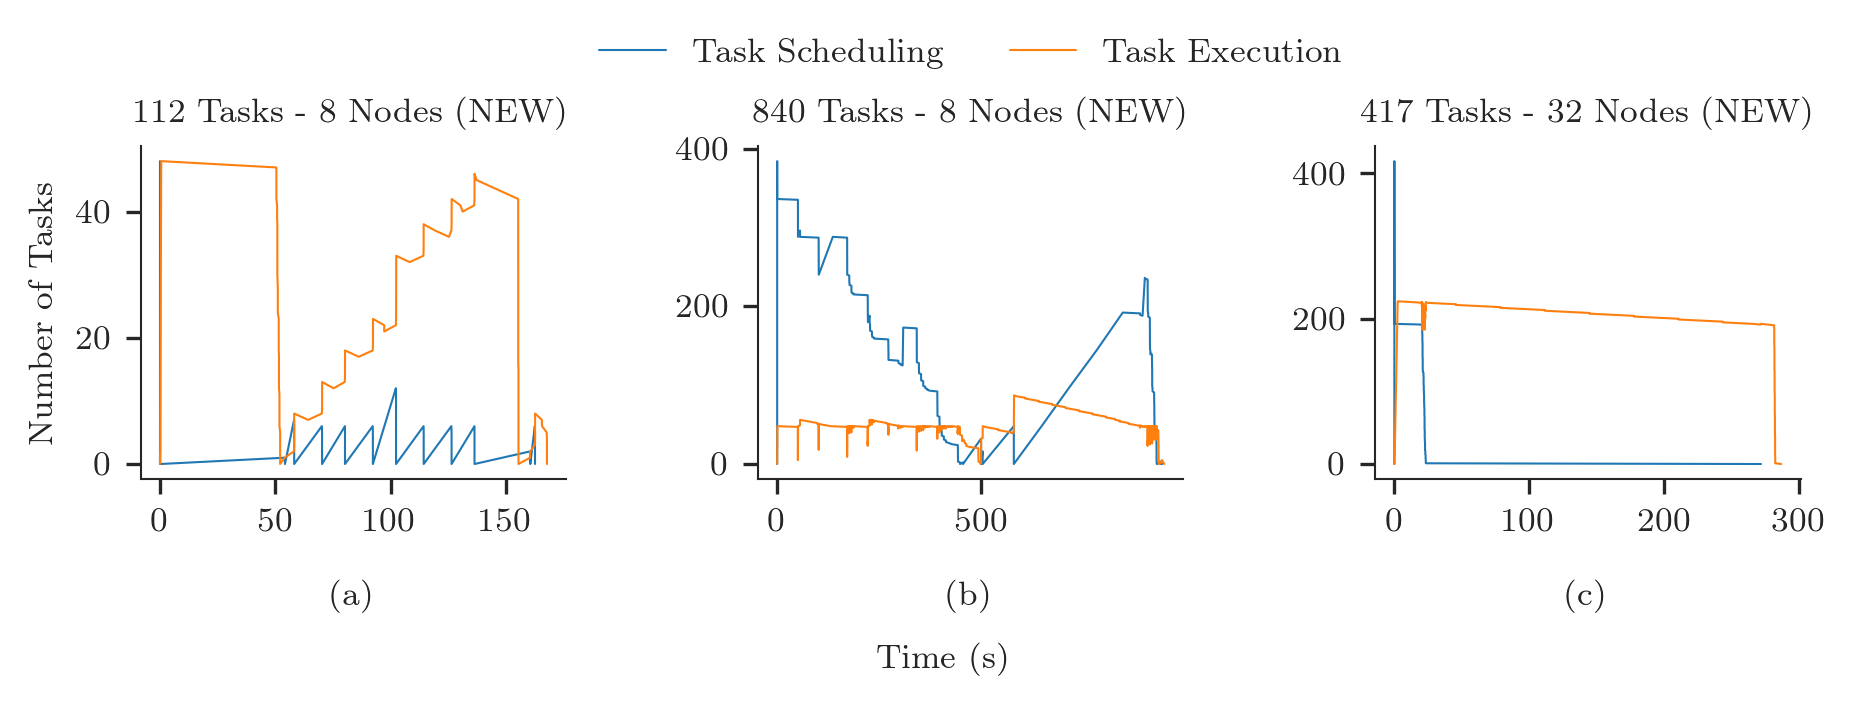

In [4]:
# sessions you want to plot
splot = [os.path.basename(s) for s in sessions]
nsids = len(splot)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels
j = 'a'
for i, sid in enumerate(splot):
    #sp = sdir+sid
    #session = ra.Session(sp, 'radical.pilot')
    #pilots  = session.filter(etype='pilot', inplace=False)
    #tasks   = session.filter(etype='task' , inplace=False)
    pairs = {'Task Scheduling'  : [{ru.STATE: 'AGENT_SCHEDULING'},
                                   {ru.EVENT: 'schedule_ok'     } ],
             'Task Execution'   : [{ru.EVENT: 'exec_start'      },
                                   {ru.EVENT: 'exec_stop'       } ]}
    time_series = {pair: ss[sid]['s'].concurrency(event=pairs[pair]) for pair in pairs}
    #fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

    if sid == 're.session.login1.litan.018960.0000' or 're.session.login3.litan.018959.0000':
        axarr[i].set_title('%s Tasks - %s Nodes (NEW)' % (ss[sid]['ntask'],
                        int(ss[sid]['nnodes'])))
    else:
        axarr[i].set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'],
                        int(ss[sid]['nnodes'])))
    axarr[i].set_xlabel('(%s)' % j, labelpad=10)
    
    for name in time_series:
        zero = min([e[0] for e in time_series[name]])
        x = [e[0]-zero for e in time_series[name]]
        y = [e[1] for e in time_series[name]]
        axarr[i].plot(x, y, label=ra.to_latex(name), color=next(colors))
    
    if i == 0:
        axarr[i].set_ylabel('Number of Tasks')
        #axarr[i].set_xlabel('Time (s)')
    
    # update session id and raw identifier letter
    j = chr(ord(j) + 1)

# Add legend
#fig.legend(legend, [m[0] for m in metrics],
#           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
axarr[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5,1.4))

# Add axes labels
fig.text(0.5, -0.3, 'Time (s)', ha='center')